In [1]:
import tempfile
import pickle as pkl
from pathlib import Path
import os
import yaml

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

import mlflow
import dvc.api

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import GPT2Tokenizer

import shap

from auxiliar import crear_ensemble_donadas

In [2]:
# Paramètres
with open("config.yml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

INPUT_FICHIER_WIKI_TEXTE = config["camins"]["texte"]["fichier_wiki_texte"]

INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI = dvc.api.get_url(config["camins"]["etiquetas"]["fichier_wiki_etiquetas_aleatori"])
INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = dvc.api.get_url(config["camins"]["etiquetas"]["fichier_wiki_etiquetas_automatic"])
INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = dvc.api.get_url(config["camins"]["etiquetas"]["fichier_wiki_etiquetas_entropia"])

INPUT_DOSSIER_TOKENIZAIRE = config["camins"]["tokenizaire"]["dossier_tokenizaire"]

OUTPUT_PREDICCIONS = config["camins"]["classificador"]["xgboost"]["prediccions"]
OUTPUT_SELECCION_PAGINAS = config["camins"]["classificador"]["xgboost"]["seleccion_paginas"]
OUTPUT_DOSSIER_MODEL = config["camins"]["classificador"]["xgboost"]["dossier_model"]

LONGOR_MIN = int(config["parametres"]["longor_min"])
LONGOR_MAX = config["parametres"]["longor_max"]
if LONGOR_MAX == "inf":
    LONGOR_MAX = np.inf

TALHA_TEST = 0.2

OPTIMIZACION_BAYESIANA = False

In [3]:
texte_df = pd.read_csv(INPUT_FICHIER_WIKI_TEXTE)
longor_texte = texte_df["Texte"].apply(len)
texte_df = texte_df[(longor_texte > LONGOR_MIN) & (longor_texte < LONGOR_MAX)].reset_index(drop=True)

dict_dialectes_df = {
    "aleatori": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI),
    "automatic": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC),
    "entropia": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA),
}

texte_etiquetas_df = crear_ensemble_donadas(
    texte_df=texte_df,
    dict_dialectes_df=dict_dialectes_df,
)
texte_etiquetas_df

,Article,Dialecte,Texte
0,Vieux-Champagne,lengadocian,vieux-champagne es una situada dins lo de sèin...
1,Ereditat,lengadocian,lereditat (del latin hereditas çò que s'erita ...
2,White_Town,lengadocian,white town es un projècte britanic de musica e...
3,Puigverd_d'Agramunt,lengadocian,puigverd d'agramunt es un de la
4,La_Grande_Montagne,lengadocian,la grande montagne es una de sant bartomieu di...
...,...,...,...
8289,Roger_de_Flor,provençal,ruggero da fiore ò rutger von blum (vèrs 1267 ...
8290,Aurelian_(emperaire_roman),provençal,aurelian en latin: lucius domitius aurelianus ...
8291,Miranda_(Gers),gascon,miranda (mirande en ) qu'ei ua ancianas ?
8292,Lekunberri_(Baisha_Navarra),gascon,lekunberri (


In [4]:
metadata = {
    **{
        "md5_etiquetas_aleatori": INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI.split("/")[-1],
        "md5_etiquetas_automatic": INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC.split("/")[-1],
        "md5_etiquetas_entropia": INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA.split("/")[-1],
        "git_tag": dvc.api.all_tags()[-1],
        "talha_test": TALHA_TEST,
        "longor_min": LONGOR_MIN,
        "longor_max": LONGOR_MAX,
        "optimizacion_bayesiana": OPTIMIZACION_BAYESIANA,
    },
    **{f"nrows_{k}": v.shape[0] for k, v in dict_dialectes_df.items()},
}
metadata

{'md5_etiquetas_aleatori': 'b8d99a303f34db4c594bd2f8bc7eee',
 'md5_etiquetas_automatic': 'fa9d05c34dcee29c42f69fc677b304',
 'md5_etiquetas_entropia': '8f6f4fa2a09203771f7b946f9d4226',
 'git_tag': 'v0.1.0',
 'talha_test': 0.2,
 'longor_min': 50,
 'longor_max': inf,
 'optimizacion_bayesiana': False,
 'nrows_aleatori': 570,
 'nrows_automatic': 8117,
 'nrows_entropia': 0}

In [5]:
texte_etiquetas_entrenament, texte_etiquetas_test = train_test_split(texte_etiquetas_df, test_size=TALHA_TEST)

In [6]:
# Crear sac a mots
tokenizaire = GPT2Tokenizer.from_pretrained(
    INPUT_DOSSIER_TOKENIZAIRE,
    do_lower_case=True,
)
tokens_entrenament = texte_etiquetas_entrenament["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_test = texte_etiquetas_test["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_tot = texte_df["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))

vectorizador = CountVectorizer()
bow_entrenament = vectorizador.fit_transform(tokens_entrenament)
bow_test = vectorizador.transform(tokens_test)
bow_tot = vectorizador.transform(tokens_tot)

# Codificar los dialèctes
codificador_ordinal = OrdinalEncoder()
etiquetas_entrenament = codificador_ordinal.fit_transform(texte_etiquetas_entrenament[["Dialecte"]]).astype(int)
etiquetas_test = codificador_ordinal.transform(texte_etiquetas_test[["Dialecte"]]).astype(int)

In [7]:
melhor_params = {}
if OPTIMIZACION_BAYESIANA:

    def evaluar(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        kf = KFold(n_splits=3)
        f1_scores = []

        for train_index, valid_index in kf.split(bow_entrenament):

            xgb = XGBClassifier(
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                n_estimators=int(n_estimators),
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
            )
            xgb.fit(
                bow_entrenament[train_index],
                etiquetas_entrenament[train_index],
                sample_weight=compute_sample_weight("balanced", etiquetas_entrenament[train_index]),
                verbose=False,
            )
            etiquetas_predichas = xgb.predict(bow_entrenament[valid_index])
            score = f1_score(etiquetas_entrenament[valid_index], etiquetas_predichas, average="macro")
            f1_scores.append(score)

        return np.mean(f1_scores)

    limits = {
        "max_depth": (3, 12),
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 200),
        "gamma": (0, 0.5),
        "min_child_weight": (1, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    }

    optimizaire = BayesianOptimization(f=evaluar, pbounds=limits, random_state=63, verbose=2)

    optimizaire.maximize(init_points=10, n_iter=20)

    melhor_params = optimizaire.max["params"]
    melhor_params["max_depth"] = int(melhor_params["max_depth"])
    melhor_params["n_estimators"] = int(melhor_params["n_estimators"])

2024/07/11 20:32:11 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost' does not exist. Creating a new experiment.


Exactitud: 0.946955997588909
Precision: 0.8045357554023987
Rappel: 0.8488126279956165
F1: 0.8175581942690582


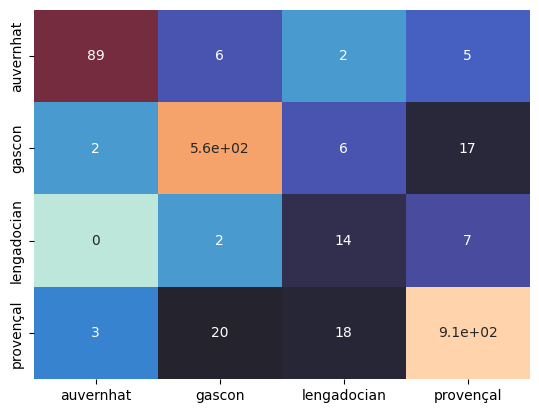

In [8]:
# Initialize MLflow
mlflow.set_experiment("XGBoost")
os.makedirs("mlruns", exist_ok=True)

# Start an MLflow run
with mlflow.start_run():

    # Entrenar e gardar lo darrièr model
    xgb_final = XGBClassifier(**melhor_params)

    xgb_final.fit(
        bow_entrenament,
        etiquetas_entrenament,
        sample_weight=compute_sample_weight("balanced", etiquetas_entrenament),
    )
    mlflow.log_params(melhor_params)
    mlflow.log_params(metadata)

    # Predire e evaluar lo model
    y_pred_test = xgb_final.predict(bow_test).reshape(-1, 1)

    # Transformar las etiquetas numericas en etiquetas textualas
    dialecte_obs_test = codificador_ordinal.inverse_transform(etiquetas_test)
    dialecte_pred_test = codificador_ordinal.inverse_transform(y_pred_test)

    # Exactitud, Precision, Rappel, F1
    exactitud = accuracy_score(dialecte_obs_test, dialecte_pred_test)
    precision, rappel, f1, _ = precision_recall_fscore_support(
        dialecte_obs_test,
        dialecte_pred_test,
        average="macro",
    )
    print(f"Exactitud: {exactitud}\nPrecision: {precision}\nRappel: {rappel}\nF1: {f1}")
    mlflow.log_metric("exactitud", exactitud)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("rappel", rappel)
    mlflow.log_metric("f1", f1)

    # Matritz de confusion
    matritz_confusion = confusion_matrix(dialecte_obs_test, dialecte_pred_test)
    matritz_confusion_df = pd.DataFrame(
        matritz_confusion,
        index=codificador_ordinal.categories_[0],
        columns=codificador_ordinal.categories_[0],
    )
    fig = sns.heatmap(np.log(matritz_confusion_df + 1), annot=matritz_confusion_df, cbar=None, cmap="icefire")
    with tempfile.NamedTemporaryFile(suffix=".png") as temp_file:
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="images")

In [9]:
with open(Path(OUTPUT_DOSSIER_MODEL) / Path("vectorizador.pkl"), "wb") as f:
    pkl.dump(vectorizador, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("codificador_ordinal.pkl"), "wb") as f:
    pkl.dump(codificador_ordinal, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("classificador.pkl"), "wb") as f:
    pkl.dump(xgb_final, f)

In [10]:
# Generar prediccions per totes los articles
y_pred_tot = xgb_final.predict(bow_tot).reshape(-1, 1)
y_prob_tot = xgb_final.predict_proba(bow_tot)
entropia_tot = np.sum(-y_prob_tot * np.log(y_prob_tot), axis=1)
resultats_df = pd.DataFrame(
    {
        "Article": texte_df["Article"],
        "Prediccion": codificador_ordinal.inverse_transform(y_pred_tot).reshape(-1),
        "Entropia": entropia_tot.reshape(-1),
    }
)
resultats_df = pd.concat(
    [resultats_df, pd.DataFrame(y_prob_tot, columns=codificador_ordinal.categories_[0])],
    axis=1,
)
resultats_df = resultats_df.merge(texte_etiquetas_df[["Article", "Dialecte"]], on="Article", how="left")
resultats_df.to_csv(OUTPUT_PREDICCIONS, index=False)
resultats_df.sort_values("Entropia", ascending=False)["Article"].to_csv(
    OUTPUT_SELECCION_PAGINAS, index=False, header=False
)
resultats_df.sort_values("Entropia", ascending=False)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
18105,Jòcs_Paralimpics,auvernhat,1.385675,2.652711e-01,0.245989,2.451067e-01,2.436329e-01,NaN
43925,Montanha,gascon,1.385498,2.379515e-01,0.265013,2.449791e-01,2.520564e-01,NaN
10272,Neuilly-en-Dun,provençal,1.383218,2.559507e-01,0.216972,2.630081e-01,2.640689e-01,NaN
6291,Neuilly-en-Sancerre,provençal,1.383218,2.559507e-01,0.216972,2.630081e-01,2.640689e-01,NaN
45056,Africa_Australa,lengadocian,1.380183,2.330680e-01,0.264452,2.870052e-01,2.154749e-01,NaN
...,...,...,...,...,...,...,...,...
64110,Guèrra_d'Etiopia,provençal,0.000034,4.440701e-07,0.000001,5.650401e-07,9.999977e-01,NaN
39490,Pardias-Pietat,gascon,0.000032,1.679968e-06,0.999998,3.149475e-07,1.846822e-07,gascon
53993,Lily_Laskine,gascon,0.000028,5.717843e-07,0.999998,1.560553e-07,1.145929e-06,gascon
28199,Mandolina,gascon,0.000022,1.696629e-07,0.999999,5.961465e-07,6.796698e-07,gascon


<Axes: xlabel='Prediccion', ylabel='Entropia'>

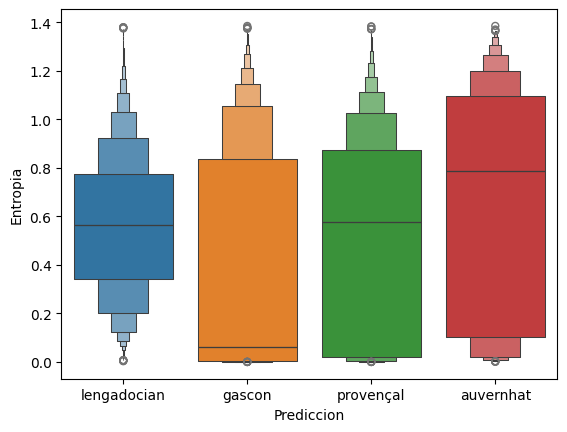

In [11]:
sns.boxenplot(data=resultats_df, x="Prediccion", y="Entropia", hue="Prediccion")

In [12]:
resultats_df.query('Dialecte.isnull() & Prediccion == "lengadocian"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
45056,Africa_Australa,lengadocian,1.380183,0.233068,0.264452,0.287005,0.215475,NaN
28208,Coscós,lengadocian,1.379986,0.231231,0.221379,0.295272,0.252118,NaN
61099,Sofrinhac,lengadocian,1.379025,0.221620,0.263053,0.293592,0.221736,NaN
61188,Margarida_Priolo,lengadocian,1.377846,0.253936,0.209488,0.299481,0.237095,NaN
31234,Suidae,lengadocian,1.375142,0.262833,0.224416,0.305086,0.207666,NaN
24734,Asia_Occidentala,lengadocian,1.373312,0.240525,0.272913,0.296188,0.190373,NaN
14924,Africa_de_l'Èst,lengadocian,1.373312,0.240525,0.272913,0.296188,0.190373,NaN
66322,Africa_Centrala,lengadocian,1.373312,0.240525,0.272913,0.296188,0.190373,NaN
15821,Eschornhac,lengadocian,1.371366,0.191898,0.231917,0.308037,0.268148,NaN
23816,Isabella_Rossellini,lengadocian,1.368877,0.206695,0.268463,0.318683,0.206159,NaN


In [13]:
resultats_df.query('Dialecte.isnull() & Prediccion == "auvernhat"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
18105,Jòcs_Paralimpics,auvernhat,1.385675,0.265271,0.245989,0.245107,0.243633,NaN
54801,Mairona,auvernhat,1.370865,0.303569,0.197127,0.281318,0.217985,NaN
535,Robilant,auvernhat,1.367036,0.297715,0.177823,0.289221,0.235241,NaN
52677,Jason,auvernhat,1.365265,0.313333,0.172970,0.251630,0.262067,NaN
54496,Lo_Mètge_per_fòrça,auvernhat,1.364776,0.332595,0.206823,0.201501,0.259081,NaN
73146,Sonac_(Carcin),auvernhat,1.363020,0.316739,0.286854,0.211670,0.184738,NaN
33799,Aretha_Franklin,auvernhat,1.360085,0.320504,0.285204,0.220028,0.174264,NaN
55502,Vilas_de_l'Egipte_antica,auvernhat,1.357551,0.315745,0.170461,0.216681,0.297112,NaN
18525,Faraons_per_òrdre_cronologic,auvernhat,1.357551,0.315745,0.170461,0.216681,0.297112,NaN
71498,Dius_egipcians_per_relacion,auvernhat,1.357551,0.315745,0.170461,0.216681,0.297112,NaN


In [14]:
texte_etiquetas_df.groupby("Dialecte")["Article"].count()

Dialecte
auvernhat       512
gascon         2847
lengadocian     157
provençal      4778
Name: Article, dtype: int64

In [15]:
resultats_df.groupby("Prediccion")["Article"].count()

Prediccion
auvernhat       1141
gascon         10732
lengadocian    49636
provençal      20099
Name: Article, dtype: int64

In [16]:
# explicador = shap.TreeExplainer(xgb_final)
# shap_df = pd.DataFrame(explicador(bow_test), index=texte_etiquetas_test["Article"], columns=vocab_list)

In [17]:
vocab = {v: k for k, v in vectorizador.vocabulary_.items()}
vocab_list = [vocab[i] for i in range(len(vocab))]

fi_df = pd.DataFrame({"FI": xgb_final.feature_importances_})
fi_df["TokenIndex"] = list(range(0, fi_df.shape[0]))
fi_df["Token"] = fi_df["TokenIndex"].map(lambda x: vocab[x])
fi_df.sort_values("FI", ascending=False).head(60)

,FI,TokenIndex,Token
17121,0.087032,17121,ġua
9590,0.058125,9590,ġdei
2172,0.041648,2172,es
9862,0.028586,9862,ġdeu
15968,0.025767,15968,ġsantiago
12555,0.020459,12555,ġlei
9494,0.019330,9494,ġdau
9613,0.017302,9613,ġdels
12680,0.011038,12680,ġlingã¼istica
570,0.010155,570,alimenta
